Here is the agent we are analyzing, a 20 bin PPO trained with the default reward:

In [ ]:
agent_name = 'default_PPO_citylearn_challenge_2022_phase_2_Building_6_20_bins_0'

In [1]:
from stable_baselines3 import PPO

from citylearn.data import DataSet

from art.attacks.evasion import AutoConjugateGradient as ACG

import pandas as pd
import numpy as np

import KBMproject.utilities as utils

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
dataset_name = 'citylearn_challenge_2022_phase_2' #only action is electrical storage
schema = DataSet.get_schema(dataset_name)

In [3]:
agent = PPO.load(path=f"Models/Victim/{agent_name}")
print('Model loaded from storage')

Model loaded from storage


In [4]:
bins = agent.action_space[0].n
env = utils.make_discrete_env(schema=schema,  
                        action_bins=bins,
                        seed=42)

In [5]:
agent.policy

ActorCriticPolicy(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (pi_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (vf_features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (mlp_extractor): MlpExtractor(
    (policy_net): Sequential(
      (0): Linear(in_features=31, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
    )
    (value_net): Sequential(
      (0): Linear(in_features=31, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=256, bias=True)
      (3): Tanh()
    )
  )
  (action_net): Linear(in_features=256, out_features=20, bias=True)
  (value_net): Linear(in_features=256, out_features=1, bias=True)
)

In [6]:
from copy import deepcopy
value_net = deepcopy(agent.policy.mlp_extractor.value_net) #copies shared net rather than referencing
value_net.add_module('value', agent.policy.value_net)

In [7]:
from art.estimators.classification import PyTorchClassifier as classifier
from torch.nn import CrossEntropyLoss
value = classifier(model=value_net,
                   nb_classes=env.action_space[0].n,
                   loss=CrossEntropyLoss(),
                   input_shape=agent.observation_space.shape,
                   device_type='gpu')

In [8]:
obs_list = []
a_list = []
v_list = []

observations = env.reset()

while not env.done:
    obs_list.append(observations)
    v_list.append(value.predict(np.expand_dims(observations, axis=0))[0][0])
    actions, _ = agent.predict(observations, deterministic=True)
    a_list.append(actions)
    observations, _, _, _ = env.step(actions)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


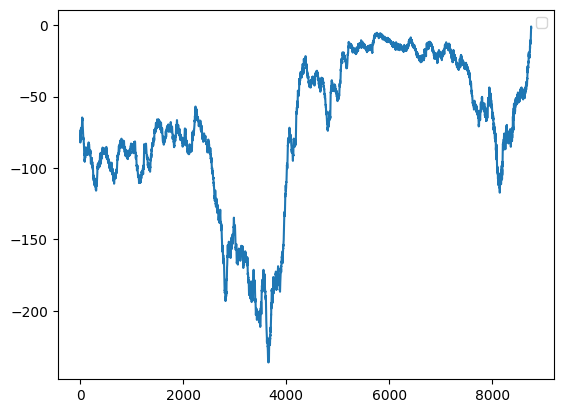

In [9]:
plt.plot(v_list)
plt.legend()
plt.show()

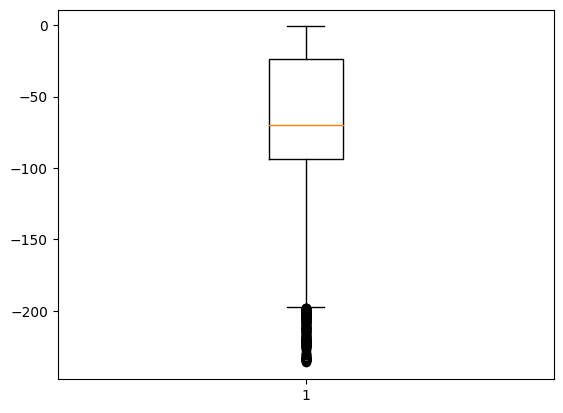

In [12]:
plt.boxplot(v_list)
plt.show()

In [13]:
pds_v = pd.Series(v_list)
pds_v.describe()

count    8759.000000
mean      -72.549812
std        52.900219
min      -236.113663
25%       -93.586342
50%       -70.171570
75%       -24.083179
max        -0.983759
dtype: float64

In [14]:
pds_v.median()

-70.17157